
## Helpful Functions for Tensorflow (Little Gems)

The following functions will be used with TensorFlow to help preprocess the data.  They allow you to build the feature vector for a neural network. 

* Predictors/Inputs 
    * Fill any missing inputs with the median for that column.  Use **missing_median**.
    * Encode textual/categorical values with **encode_text_dummy**.
    * Encode numeric values with **encode_numeric_zscore**.
* Output
    * Discard rows with missing outputs.
    * Encode textual/categorical values with **encode_text_index**.
    * Do not encode output numeric values.
* Produce final feature vectors (x) and expected output (y) with **to_xy**.

In [2]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
from sklearn import metrics


import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


## Switch and Verify GPU

### To enable GPU backend for your notebook. Runtime->Change runtime type->Hardware Accelerator->GPU.

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D


tf.test.gpu_device_name()

'/device:GPU:0'

### If the above code output '/device:GPU:0',  you have switched to GPU successfully and you are ready to go. 



## Part I:   Image classification without transfer learning

https://www.cs.toronto.edu/~kriz/cifar.html

In [4]:
num_classes = 10
mapping = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
outcomes = list(range(0, num_classes))

In [5]:
#  Load cifar-10 data and split it to training and test





# The data split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


In [7]:
# print out data shape

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


In [8]:
# print out a random image in x_train as numpy array
x_train[15]

array([[[100, 168, 231],
        [100, 168, 229],
        [101, 167, 230],
        ...,
        [ 95, 165, 231],
        [ 94, 165, 228],
        [ 95, 167, 229]],

       [[103, 170, 230],
        [103, 168, 228],
        [104, 168, 226],
        ...,
        [ 97, 167, 229],
        [ 97, 166, 227],
        [ 97, 168, 229]],

       [[107, 174, 233],
        [106, 172, 230],
        [106, 173, 229],
        ...,
        [100, 170, 230],
        [100, 170, 230],
        [101, 172, 232]],

       ...,

       [[165, 178, 177],
        [159, 170, 167],
        [167, 177, 170],
        ...,
        [ 75, 117, 154],
        [ 75, 120, 157],
        [ 72, 120, 158]],

       [[158, 174, 172],
        [173, 186, 182],
        [182, 193, 188],
        ...,
        [ 76, 119, 154],
        [ 75, 119, 153],
        [ 77, 121, 154]],

       [[161, 176, 174],
        [162, 176, 172],
        [160, 171, 169],
        ...,
        [ 98, 137, 167],
        [129, 160, 183],
        [162, 185, 202]]

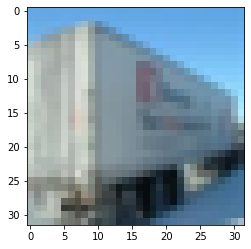

In [9]:
# print it out as image

import matplotlib.pyplot as plt


plt.imshow(x_train[15])

In [10]:
# Convert y_train from 2D to 1D 

y_train = y_train.reshape(50000)


In [11]:
y_train.shape

# expected output: (50000,)

(50000,)

In [12]:
# Convert y_test from 2D to 1D 

y_test = y_test.reshape(10000)


In [13]:
y_test.shape
# expected output: (10000,)

(10000,)

In [14]:
# Convert class vectors to one hot format

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [15]:
# Convert data from int to float and normalize it


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

###  Write your code in the cell below to create a CNN model which contains the following types of operations (layers):   

- Conv2D
- Activation
- MaxPooling2D
- Flatten
- Dropout
- Dense

### (optional) You are also encouraged to create multiple models with different activiation functions, different numbers of neurons and layers for performance comparison.

In [16]:
batch_size = 64
shape = x_train.shape[1:]
epochs = 60
kernel = (3,3)
checkpointer = ModelCheckpoint(filepath="./best_weights_fairclass1.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(2):
  model = Sequential()
  model.add(Conv2D(32, kernel_size = kernel, activation= 'relu', strides = (1, 1), padding='valid', input_shape = shape))

  model.add(Conv2D(64, kernel_size=kernel, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides = None))
  model.add(Dropout(0.25))
  model.add(Conv2D(128, kernel_size=kernel, activation='relu'))
  model.add(Conv2D(256, kernel_size=kernel, activation='relu'))

  model.add(MaxPooling2D(pool_size=(2, 2), strides=None))
  model.add(Dropout(0.25))
  
  model.add(Flatten())
 
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  model.summary()
  model.compile(loss = 'categorical_crossentropy', optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10,verbose = 2, mode = 'auto')
  model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = epochs, batch_size= batch_size,verbose=2,  callbacks=[monitor, checkpointer])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 256)         0

### Write your code in the cell below for compile, earlystopping and fit. Notice that you should use earlystopping

### Write your code in the cell below to print out the Precision, Recall,  F1 score, and classification_*report*

### Include your findings in the project report. 

Accuracy: 0.8004
F1-score Averaged: 0.7991278766608453
Confusing Matrix:
[[827  12  39  10  20   1   7  11  50  23]
 [  7 892   2   3   3   3   9   1  20  60]
 [ 57   1 693  36  72  40  69  22   8   2]
 [ 16   4  68 604  59 121  84  28   8   8]
 [  7   1  52  43 783  20  44  42   6   2]
 [  6   0  47 132  45 699  29  36   3   3]
 [  4   0  27  34  14  10 892  10   7   2]
 [ 11   0  29  29  37  34   7 847   1   5]
 [ 51  19  10   8   3   1   8   2 884  14]
 [ 19  43   3   8   3   2   5   7  27 883]]


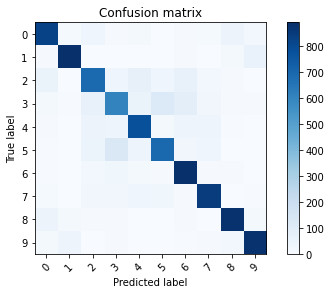

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1000
           1       0.92      0.89      0.90      1000
           2       0.71      0.69      0.70      1000
           3       0.67      0.60      0.63      1000
           4       0.75      0.78      0.77      1000
           5       0.75      0.70      0.72      1000
           6       0.77      0.89      0.83      1000
           7       0.84      0.85      0.84      1000
           8       0.87      0.88      0.88      1000
           9       0.88      0.88      0.88      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



In [17]:
model.load_weights("./best_weights_fairclass1.hdf5")
pred = model.predict(x_test)
true = np.argmax(y_test, axis = 1)
pred = np.argmax(pred, axis = 1)
print("Accuracy:", metrics.accuracy_score(true, pred))
print("F1-score Averaged:", metrics.f1_score(true, pred, average = 'weighted'))
cm = metrics.confusion_matrix(true, pred)
outcomes = list(range(0, num_classes))
print("Confusing Matrix:")
print(cm)
plot_confusion_matrix(cm, outcomes)
plt.show()
print(metrics.classification_report(true, pred))

### Write your code in the cell below to show 3-5 images in the test set as well as their true labels and their labels predicted by your model.

### Include your findings in the project report.

True Label: 5, dog
Predicted Label: 5, dog


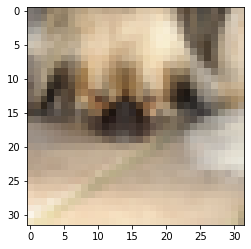

True Label: 8, ship
Predicted Label: 8, ship


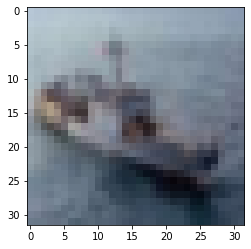

True Label: 2, bird
Predicted Label: 2, bird


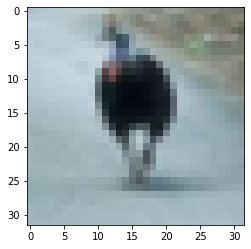

True Label: 8, ship
Predicted Label: 8, ship


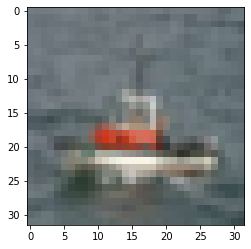

True Label: 2, bird
Predicted Label: 4, deer


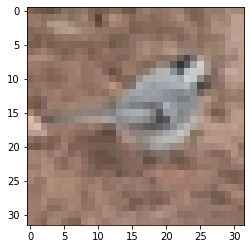

In [19]:
for i in range(5):
  image_index = np.random.randint(0, x_test.shape[0], 1)[0]
  image = x_test[image_index]  
  print("True Label:", str(true[image_index]) + ",", mapping[true[image_index]])
  print("Predicted Label:", str(pred[image_index]) + ",", mapping[pred[image_index]])
  plt.imshow(image)
  plt.show()
  

**Hyper Tunning** 






Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 31, 31, 32)        416       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 64)        8256      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 15, 15, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 14400)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               7373312   
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)              

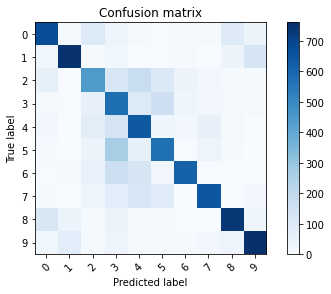

              precision    recall  f1-score   support

           0       0.70      0.68      0.69      1000
           1       0.82      0.75      0.78      1000
           2       0.53      0.45      0.48      1000
           3       0.39      0.58      0.47      1000
           4       0.51      0.64      0.57      1000
           5       0.57      0.57      0.57      1000
           6       0.83      0.61      0.71      1000
           7       0.78      0.65      0.71      1000
           8       0.77      0.74      0.75      1000
           9       0.75      0.76      0.75      1000

    accuracy                           0.64     10000
   macro avg       0.67      0.64      0.65     10000
weighted avg       0.67      0.64      0.65     10000

True Label: 0, airplane
Predicted Label: 7, horse


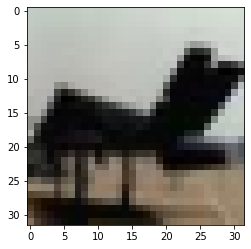

True Label: 2, bird
Predicted Label: 3, cat


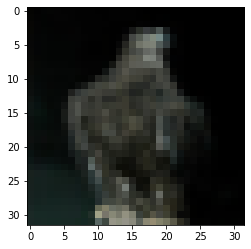

True Label: 9, truck
Predicted Label: 9, truck


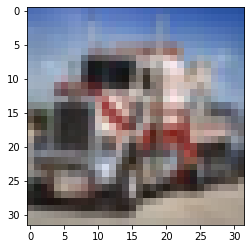

True Label: 9, truck
Predicted Label: 3, cat


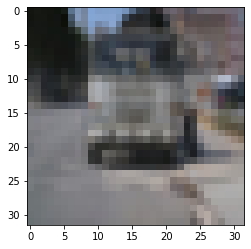

True Label: 1, automobile
Predicted Label: 9, truck


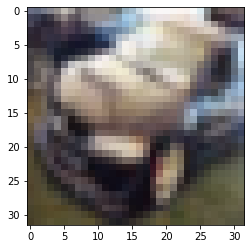

In [21]:
batch_size = 32
shape = x_train.shape[1:]
epochs = 60
kernel = (2, 2)
checkpointer = ModelCheckpoint(filepath="./best_weights_fairclass3.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(2):
  model = Sequential()
  model.add(Conv2D(32, kernel_size = kernel, activation= 'sigmoid', strides = (1, 1), padding='valid', input_shape = shape))

  model.add(Conv2D(64, kernel_size=kernel, activation='sigmoid'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides = None))
  model.add(Dropout(0.25))
 
  
  model.add(Flatten())
 
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  model.summary()
  model.compile(loss = 'categorical_crossentropy', optimizer=Adam(lr=0.01, decay=1e-6), metrics=['accuracy'])
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5,verbose = 2, mode = 'auto')
  model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = epochs, batch_size= batch_size,verbose=2,  callbacks=[monitor, checkpointer])
model.load_weights("./best_weights_fairclass3.hdf5")
pred = model.predict(x_test)
true = np.argmax(y_test, axis = 1)
pred = np.argmax(pred, axis = 1)
print("Accuracy:", metrics.accuracy_score(true, pred))
print("F1-score Averaged:", metrics.f1_score(true, pred, average = 'weighted'))
cm = metrics.confusion_matrix(true, pred)
outcomes = list(range(0, num_classes))
print("Confusing Matrix:")
print(cm)
plot_confusion_matrix(cm, outcomes)
plt.show()
print(metrics.classification_report(true, pred))
for i in range(5):
  image_index = np.random.randint(0, x_test.shape[0], 1)[0]
  image = x_test[image_index]  
  print("True Label:", str(true[image_index]) + ",", mapping[true[image_index]])
  print("Predicted Label:", str(pred[image_index]) + ",", mapping[pred[image_index]])
  plt.imshow(image)
  plt.show()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 31, 31, 32)        416       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 14400)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               7373312   
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)              

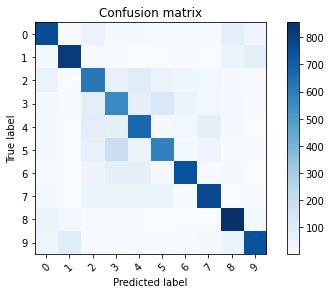

              precision    recall  f1-score   support

           0       0.75      0.76      0.75      1000
           1       0.83      0.82      0.83      1000
           2       0.59      0.62      0.61      1000
           3       0.52      0.56      0.54      1000
           4       0.64      0.68      0.66      1000
           5       0.67      0.59      0.63      1000
           6       0.81      0.75      0.78      1000
           7       0.78      0.77      0.77      1000
           8       0.76      0.85      0.80      1000
           9       0.81      0.75      0.78      1000

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.72      0.71      0.71     10000

True Label: 8, ship
Predicted Label: 8, ship


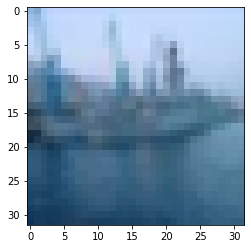

True Label: 6, frog
Predicted Label: 6, frog


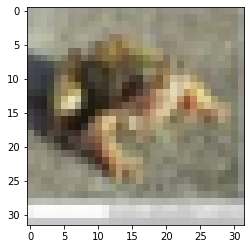

True Label: 3, cat
Predicted Label: 4, deer


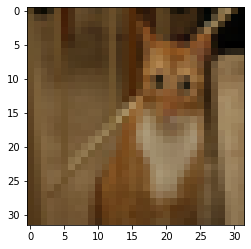

True Label: 9, truck
Predicted Label: 1, automobile


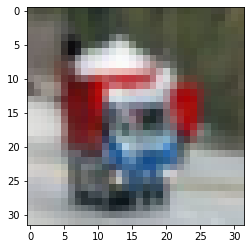

True Label: 9, truck
Predicted Label: 9, truck


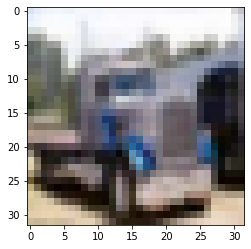

In [20]:
batch_size = 28
shape = x_train.shape[1:]
epochs = 60
kernel = (2, 2)
checkpointer = ModelCheckpoint(filepath="./best_weights_fairclass4.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(2):
  model = Sequential()
  model.add(Conv2D(32, kernel_size = kernel, activation= 'relu', strides = (1, 1), padding='valid', input_shape = shape))

  model.add(Conv2D(64, kernel_size=kernel, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides = None))
  model.add(Dropout(0.25))
 
  
  model.add(Flatten())
 
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  model.summary()
  model.compile(loss = 'categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5,verbose = 2, mode = 'auto')
  model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = epochs, batch_size= batch_size,verbose=2,  callbacks=[monitor, checkpointer])
model.load_weights("./best_weights_fairclass4.hdf5")
pred = model.predict(x_test)
true = np.argmax(y_test, axis = 1)
pred = np.argmax(pred, axis = 1)
print("Accuracy:", metrics.accuracy_score(true, pred))
print("F1-score Averaged:", metrics.f1_score(true, pred, average = 'weighted'))
cm = metrics.confusion_matrix(true, pred)
outcomes = list(range(0, num_classes))
print("Confusing Matrix:")
print(cm)
plot_confusion_matrix(cm, outcomes)
plt.show()
print(metrics.classification_report(true, pred))
for i in range(5):
  image_index = np.random.randint(0, x_test.shape[0], 1)[0]
  image = x_test[image_index]  
  print("True Label:", str(true[image_index]) + ",", mapping[true[image_index]])
  print("Predicted Label:", str(pred[image_index]) + ",", mapping[pred[image_index]])
  plt.imshow(image)
  plt.show()





## Part II:   CNN model with Transfer Learning

In [22]:
# We load data again.   The data split between train and test sets:

(x_train, y_train), (x_test, y_test) = cifar10.load_data()



print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


### Here we would like to use one pre-trained model called VGG16.   For more details on VGG16, please go to https://neurohive.io/en/popular-networks/vgg16/


### VGG16 supports down to 48x48 images as an input. However, the resolution of our images is too low, which is (32, 32) so we need to increase the resolution.   This is called upsampling. 



### Find a way to do upsampling for each image to increase its resolution from 32x32 to 64x64. One option is to use the function resize(), which is provided by scikit-image library (https://scikit-image.org/)


### Things to note: 

#### (1) If you use resize() in scikit-image, that function also normalizes the input image so you may not want to normalize twice.

#### (2) Apply upsampling to x_train and x_test seperately. 

In [23]:
import skimage.transform


new_x_train = []
for image in x_train:
  new_x_train.append(skimage.transform.resize(image, (64, 64)))

new_x_train = np.array(new_x_train)
print(new_x_train.shape)
print(new_x_train[0])
  

# this process may take about a few minutes ....

(50000, 64, 64, 3)
[[[0.17352941 0.18529412 0.18676471]
  [0.17352941 0.18529412 0.18676471]
  [0.14215686 0.15196078 0.1504902 ]
  ...
  [0.56151961 0.44926471 0.35147059]
  [0.55710784 0.4497549  0.35637255]
  [0.55710784 0.4497549  0.35637255]]

 [[0.17352941 0.18529412 0.18676471]
  [0.17352941 0.18529412 0.18676471]
  [0.14215686 0.15196078 0.1504902 ]
  ...
  [0.56151961 0.44926471 0.35147059]
  [0.55710784 0.4497549  0.35637255]
  [0.55710784 0.4497549  0.35637255]]

 [[0.08921569 0.10098039 0.10147059]
  [0.08921569 0.10098039 0.10147059]
  [0.05784314 0.06372549 0.06323529]
  ...
  [0.5002451  0.36936275 0.25245098]
  [0.50269608 0.3747549  0.26323529]
  [0.50269608 0.3747549  0.26323529]]

 ...

 [[0.69558824 0.53455882 0.35098039]
  [0.69558824 0.53455882 0.35098039]
  [0.68088235 0.50367647 0.26078431]
  ...
  [0.41617647 0.28504902 0.17941176]
  [0.38186275 0.25906863 0.17352941]
  [0.38186275 0.25906863 0.17352941]]

 [[0.68872549 0.54485294 0.40588235]
  [0.68872549 0.54

In [24]:
new_x_test = []
for image in x_test:
  new_x_test.append(skimage.transform.resize(image, (64, 64)))

new_x_test = np.array(new_x_test)
print(new_x_test.shape)
print(new_x_test[0])



# this process may take about a few minutes ....

(10000, 64, 64, 3)
[[[0.61421569 0.4379902  0.18995098]
  [0.61421569 0.4379902  0.18995098]
  [0.61519608 0.43553922 0.18161765]
  ...
  [0.48431373 0.35171569 0.13553922]
  [0.46666667 0.34142157 0.13210784]
  [0.46666667 0.34142157 0.13210784]]

 [[0.61421569 0.4379902  0.18995098]
  [0.61421569 0.4379902  0.18995098]
  [0.61519608 0.43553922 0.18161765]
  ...
  [0.48431373 0.35171569 0.13553922]
  [0.46666667 0.34142157 0.13210784]
  [0.46666667 0.34142157 0.13210784]]

 [[0.60147059 0.4375     0.18946078]
  [0.60147059 0.4375     0.18946078]
  [0.6004902  0.43406863 0.17230392]
  ...
  [0.48431373 0.35318627 0.13014706]
  [0.47058824 0.34583333 0.13161765]
  [0.47058824 0.34583333 0.13161765]]

 ...

 [[0.22401961 0.43529412 0.63357843]
  [0.22401961 0.43529412 0.63357843]
  [0.20735294 0.41372549 0.59877451]
  ...
  [0.10882353 0.30612745 0.47843137]
  [0.08921569 0.27132353 0.44117647]
  [0.08921569 0.27132353 0.44117647]]

 [[0.21715686 0.42352941 0.62230392]
  [0.21715686 0.42

In [25]:
x_train  = new_x_train
x_test = new_x_test



### Write your code in the cell below to do the following:

- First convert y_train and y_test from 2D to 1D by using reshape() function 
- Next apply one-hot encoding to y_train and y_test by using tf.keras.utils.to_categorical() function

In [26]:
num_classes = 10
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])
print(y_train.shape)
print(y_test.shape)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)



(50000,)
(10000,)


In [27]:
# double check shape

print(y_train.shape)
print(y_test.shape)


# expected output:  (50000, 10)
# expected output:  (10000, 10)

(50000, 10)
(10000, 10)


###  Load the pre-trained VGG16 model.  Write your code in the cell below to add each layer in VGG16 (excluding the top layers) to your new model.  

In [28]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))   #  first hidden layer


model = Sequential()

  
# write your code here
for layer in vgg_model.layers:
  model.add(layer)




# print out the model summary
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)      

### Write your code in the cell below to freeze the weights in each layer in the new model

In [29]:
for layer in model.layers:
  layer.trainable = False


###  Write your code in the cell below to add some "Dense" layers as top layers.

- Donot forget the output layer
- Choose the right activation fucntion for the output layer

In [30]:
model.add(Flatten())


# Add some "Dense" layers here, including output layer
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)      

###  Write your code below for compile and fit. 

### Train your new model. 

### Notice that you should use earlystopping.

In [31]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
batch_size = 32
epochs = 20
checkpointer = ModelCheckpoint(filepath="./best_weights_fairclass2.hdf5", verbose=0, save_best_only=True) # save best model
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5,verbose = 2, mode = 'auto')
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = epochs, batch_size= batch_size,verbose=2,  callbacks=[monitor, checkpointer])


# since we use GPU, the training time for each epoch for the transferred model is about 60 seconds.  
# Let it run for a few epochs. 

Epoch 1/20
1563/1563 - 58s - loss: 1.1319 - accuracy: 0.6060 - val_loss: 1.0491 - val_accuracy: 0.6270
Epoch 2/20
1563/1563 - 57s - loss: 0.9110 - accuracy: 0.6817 - val_loss: 0.8931 - val_accuracy: 0.6887
Epoch 3/20
1563/1563 - 57s - loss: 0.8219 - accuracy: 0.7129 - val_loss: 0.9196 - val_accuracy: 0.6819
Epoch 4/20
1563/1563 - 57s - loss: 0.7576 - accuracy: 0.7351 - val_loss: 0.8799 - val_accuracy: 0.6996
Epoch 5/20
1563/1563 - 57s - loss: 0.6978 - accuracy: 0.7551 - val_loss: 0.9163 - val_accuracy: 0.6917
Epoch 6/20
1563/1563 - 57s - loss: 0.6474 - accuracy: 0.7735 - val_loss: 0.9074 - val_accuracy: 0.6973
Epoch 7/20
1563/1563 - 57s - loss: 0.5968 - accuracy: 0.7903 - val_loss: 0.9323 - val_accuracy: 0.6963
Epoch 8/20
1563/1563 - 57s - loss: 0.5537 - accuracy: 0.8076 - val_loss: 0.9799 - val_accuracy: 0.6896
Epoch 9/20
1563/1563 - 57s - loss: 0.5113 - accuracy: 0.8185 - val_loss: 1.0188 - val_accuracy: 0.6886
Epoch 00009: early stopping


### Write your code below to print out the Precision, Recall, F1 score, and classification_report

### Include your findings in the project report.

Accuracy: 0.6996
F1-score Averaged: 0.6953257962496606
Confusing Matrix:
[[749  38  29  15  36   2  15  19  64  33]
 [  7 838   2   7  10   7  23  10  21  75]
 [ 73  12 526  47 138  41 106  48   6   3]
 [ 21  40  33 443  98 120 140  63  14  28]
 [ 12  14  30  22 727  18  77  86  10   4]
 [  9  15  30 142  84 539  62  95   8  16]
 [  8  18  20  25  87  18 805   8   7   4]
 [ 11  16  14  17  81  39  13 791   6  12]
 [ 52  53   8  13  22   4  12   6 797  33]
 [ 28  94   3  18  12   7  11  24  22 781]]


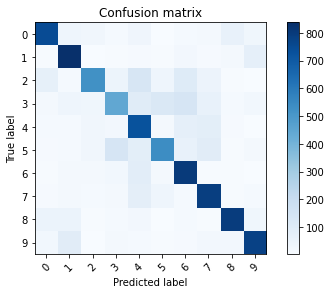

              precision    recall  f1-score   support

           0       0.77      0.75      0.76      1000
           1       0.74      0.84      0.78      1000
           2       0.76      0.53      0.62      1000
           3       0.59      0.44      0.51      1000
           4       0.56      0.73      0.63      1000
           5       0.68      0.54      0.60      1000
           6       0.64      0.81      0.71      1000
           7       0.69      0.79      0.74      1000
           8       0.83      0.80      0.82      1000
           9       0.79      0.78      0.79      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000



In [32]:
from sklearn import metrics
model.load_weights("./best_weights_fairclass2.hdf5")
pred = model.predict(x_test)
true = np.argmax(y_test, axis = 1)
pred = np.argmax(pred, axis = 1)
print("Accuracy:", metrics.accuracy_score(true, pred))
print("F1-score Averaged:", metrics.f1_score(true, pred, average = 'weighted'))
cm = metrics.confusion_matrix(true, pred)
outcomes = list(range(0, num_classes))
print("Confusing Matrix:")
print(cm)
plot_confusion_matrix(cm, outcomes)
plt.show()
print(metrics.classification_report(true, pred))


### Write your code in the cell below to show 3-5 images in the test set as well as their true labels and their labels predicted by your model with transfer learning. 

### Include your findings in the project report.

True Label: 8, ship
Predicted Label: 8, ship


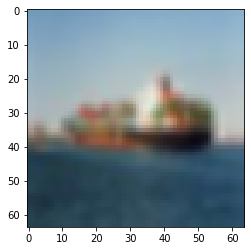

True Label: 5, dog
Predicted Label: 6, frog


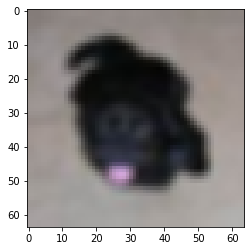

True Label: 9, truck
Predicted Label: 9, truck


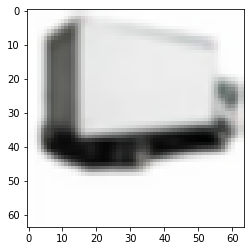

True Label: 8, ship
Predicted Label: 8, ship


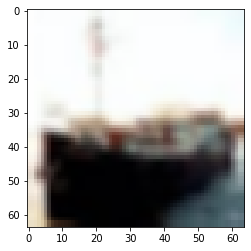

True Label: 2, bird
Predicted Label: 2, bird


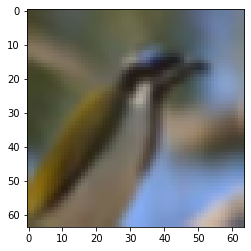

In [33]:
for i in range(5):
  image_index = np.random.randint(0, x_test.shape[0], 1)[0]
  image = x_test[image_index]  
  print("True Label:", str(true[image_index]) + ",", mapping[true[image_index]])
  print("Predicted Label:", str(pred[image_index]) + ",", mapping[pred[image_index]])
  plt.imshow(image)
  plt.show()






